In [ ]:
!pip install javalang networkx matplotlib pydot graphviz transformers torch
!apt-get install -y graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
import os
import zipfile
import subprocess
import javalang
import networkx as nx
import matplotlib.pyplot as plt
from graphviz import Digraph
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# 1. Dataset Preparation
from google.colab import files
uploaded = files.upload()

Saving Promisedataset-main.zip to Promisedataset-main.zip


In [ ]:
import zipfile
import os

with zipfile.ZipFile('Promisedataset-main.zip', 'r') as zip_ref:
    zip_ref.extractall('Promisedataset')

In [ ]:
import os

# Check the current working directory
print("Current working directory:", os.getcwd())

# List the contents of the 'Promisedataset' directory
extracted_dir = 'Promisedataset'
for root, dirs, files in os.walk(extracted_dir):
    for name in dirs:
        print("Directory:", os.path.join(root, name))
    for name in files:
        print("File:", os.path.join(root, name))


Current working directory: /content
Directory: Promisedataset/Promisedataset-main
File: Promisedataset/Zoom.lnk
File: Promisedataset/Promisedataset-main/log4j.rar
File: Promisedataset/Promisedataset-main/poi-1.5.0 src.rar
File: Promisedataset/Promisedataset-main/Jedit.rar
File: Promisedataset/Promisedataset-main/ant.rar
File: Promisedataset/Promisedataset-main/synapse.rar
File: Promisedataset/Promisedataset-main/poi 3.13 src.rar
File: Promisedataset/Promisedataset-main/xalan.rar
File: Promisedataset/Promisedataset-main/lucene.rar


In [ ]:
# Unrar if necessary
!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
import os
import subprocess

def extract_rar_files(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".rar"):
                file_path = os.path.join(root, file)
                output_dir = os.path.join(root, os.path.splitext(file)[0])
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)
                subprocess.run(['unrar', 'x', file_path, output_dir])

extract_rar_files('Promisedataset/Promisedataset-main')

In [ ]:
import os

# Dictionary to store project-wise Java files
project_files = {}

def list_java_files(directory):
    for root, dirs, files in os.walk(directory):
        # Filter to include only ant-1.5, ant-1.6, ant-1.7 directories
        if 'ant-1.5' in root or 'ant-1.6' in root or 'ant-1.7' in root:
            project_name = os.path.basename(root)
            if project_name not in project_files:
                project_files[project_name] = []
            for file in files:
                if file.endswith(".java"):
                    project_files[project_name].append(os.path.join(root, file))

# Update the directory path to your Promisedataset directory
list_java_files('Promisedataset/Promisedataset-main')

# Display the project-wise Java files for only the targeted versions
for project, files in project_files.items():
    if files:  # Only display projects with Java files
        print(f"Project: {project}")
        for file in files:
            print(f"  File: {file}")
        print(f"Total Java Files in {project}: {len(files)}\n")


Project: src
  File: Promisedataset/Promisedataset-main/ant/ant/ant-1.6/apache-ant-1.6.0/src/etc/testcases/core/loaderref/src/Task1.java
  File: Promisedataset/Promisedataset-main/ant/ant/ant-1.7/apache-ant-1.7.0/src/etc/testcases/core/loaderref/src/Task1.java
  File: Promisedataset/Promisedataset-main/ant/ant/ant-1.7/apache-ant-1.7.0/src/etc/testcases/taskdefs/rmic/src/AntTimestamp.java
  File: Promisedataset/Promisedataset-main/ant/ant/ant-1.7/apache-ant-1.7.0/src/etc/testcases/taskdefs/rmic/src/RemoteTimestamp.java
  File: Promisedataset/Promisedataset-main/ant/ant/ant-1.7/apache-ant-1.7.0/src/etc/testcases/taskdefs/rmic/src/RemoteTimestampImpl.java
  File: Promisedataset/Promisedataset-main/ant/ant/ant-1.7/apache-ant-1.7.0/src/tests/antunit/taskdefs/optional/junit/src/ExampleTest.java
Total Java Files in src: 6

Project: script
  File: Promisedataset/Promisedataset-main/ant/ant/ant-1.6/apache-ant-1.6.0/src/testcases/org/apache/tools/ant/taskdefs/optional/script/ScriptDefTest.java
 

In [ ]:
import os
import glob

# Define the paths for train, validation, and test sets
train_path = "Promisedataset/Promisedataset-main/ant/ant/ant-1.5/"
validation_path = "Promisedataset/Promisedataset-main/ant/ant/ant-1.6/"
test_path = "Promisedataset/Promisedataset-main/ant/ant/ant-1.7/"

# Function to get Java file paths
def get_java_files(directory):
    return glob.glob(os.path.join(directory, "**/*.java"), recursive=True)

# Load Java files into datasets
train_files = get_java_files(train_path)
validation_files = get_java_files(validation_path)
test_files = get_java_files(test_path)

print(f"Loaded {len(train_files)} training files.")
print(f"Loaded {len(validation_files)} validation files.")
print(f"Loaded {len(test_files)} test files.")


Loaded 727 training files.
Loaded 906 validation files.
Loaded 1891 test files.


In [ ]:
from transformers import RobertaTokenizer

# Initialize the tokenizer
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")

# Function to tokenize Java code files
def tokenize_code(file_paths, tokenizer):
    inputs = []
    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            code = f.read()
        input_ids = tokenizer.encode(code, truncation=True, padding='max_length', max_length=512)
        inputs.append(input_ids)
    return inputs

# Tokenize train, validation, and test files
train_inputs = tokenize_code(train_files, tokenizer)
validation_inputs = tokenize_code(validation_files, tokenizer)
test_inputs = tokenize_code(test_files, tokenizer)

print("Tokenization complete!")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Tokenization complete!


In [ ]:
from torch.utils.data import Dataset

# Define a dataset class for Masked Language Modeling (MLM)
class CodeDataset(Dataset):
    def __init__(self, inputs):
        self.inputs = inputs
        self.labels = inputs  # Use inputs as labels for MLM tasks

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return {
            'input_ids': self.inputs[idx],
            'labels': self.inputs[idx]
        }

# Prepare train and validation datasets
train_dataset = CodeDataset(train_inputs)
validation_dataset = CodeDataset(validation_inputs)


In [ ]:
from transformers import RobertaForMaskedLM, Trainer, TrainingArguments

# Load the pre-trained CodeBERT model for MLM
model = RobertaForMaskedLM.from_pretrained("microsoft/codebert-base")

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    evaluation_strategy="epoch"
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
)

# Fine-tune the model
trainer.train()


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,1.130461
2,No log,0.028242
3,No log,0.005911


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


TrainOutput(global_step=273, training_loss=3.4741242237580128, metrics={'train_runtime': 408.9045, 'train_samples_per_second': 5.334, 'train_steps_per_second': 0.668, 'total_flos': 574181975448576.0, 'train_loss': 3.4741242237580128, 'epoch': 3.0})

In [ ]:
!pip install transformers javalang pydot matplotlib

import javalang
import pydot
import torch
from IPython.display import Image, display
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer, RobertaModel
import os


In [ ]:
test_path = "Promisedataset/Promisedataset-main/ant/ant/ant-1.7/"
test_files = [os.path.join(root, name)
              for root, dirs, files in os.walk(test_path)
              for name in files
              if name.endswith(".java")]


In [ ]:
# Initialize tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
import numpy as np

# Function to generate AST from Java file
def generate_ast(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            code = file.read()
        tokens = javalang.tokenizer.tokenize(code)
        parser = javalang.parser.Parser(tokens)
        tree = parser.parse()
        return tree
    except Exception as e:
        print(f"Error generating AST for {file_path}: {e}")
        return None

# Function to get root-to-leaf paths in the AST
def root_to_leaf_paths(node):
    paths = []
    def traverse(current_node, current_path):
        current_path.append(current_node.__class__.__name__)
        children = list(filter(lambda x: isinstance(x, javalang.ast.Node), current_node.children))
        if not children:
            paths.append(list(current_path))
        for child in children:
            traverse(child, current_path)
        current_path.pop()
    traverse(node, [])
    return paths

# Function to aggregate embeddings for traversal paths
def aggregate_vectors_for_traversal_paths(ast):
    root_leaf_paths = root_to_leaf_paths(ast)
    embeddings_list = []
    for path in root_leaf_paths:
        code_snippet = " ".join(path)  # Convert path to a string
        inputs = tokenizer(code_snippet, return_tensors="pt", truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pool over sequence length
        embeddings_list.append(embeddings)

    if embeddings_list:
        aggregated_embedding = torch.mean(torch.stack(embeddings_list), dim=0).numpy()
        return aggregated_embedding
    else:
        return None

# Generate and store embeddings for the test set
codebert_vectors = []

for java_file in test_files:
    ast = generate_ast(java_file)
    if ast:
        final_vector = aggregate_vectors_for_traversal_paths(ast)
        if final_vector is not None:
            codebert_vectors.append(final_vector)
            print(f"Generated vector for {java_file}")
        else:
            print(f"No vector generated for {java_file} (empty paths)")
    else:
        print(f"Skipping {java_file} due to AST generation error.")

# Convert to numpy array and save to .npy file
codebert_vectors_np = np.array(codebert_vectors)
np.save("codebert_test_set_vectors.npy", codebert_vectors_np)

print(f"Generated and saved CodeBERT vectors for {len(codebert_vectors_np)} Java files in the test set.")

Generated vector for Promisedataset/Promisedataset-main/ant/ant/ant-1.7/org/apache/tools/ant/TaskContainer.java
Generated vector for Promisedataset/Promisedataset-main/ant/ant/ant-1.7/org/apache/tools/ant/DynamicAttributeNS.java
Generated vector for Promisedataset/Promisedataset-main/ant/ant/ant-1.7/org/apache/tools/ant/Project.java
Generated vector for Promisedataset/Promisedataset-main/ant/ant/ant-1.7/org/apache/tools/ant/DefaultLogger.java
Generated vector for Promisedataset/Promisedataset-main/ant/ant/ant-1.7/org/apache/tools/ant/DemuxInputStream.java
Generated vector for Promisedataset/Promisedataset-main/ant/ant/ant-1.7/org/apache/tools/ant/AntTypeDefinition.java
Generated vector for Promisedataset/Promisedataset-main/ant/ant/ant-1.7/org/apache/tools/ant/SubBuildListener.java
Generated vector for Promisedataset/Promisedataset-main/ant/ant/ant-1.7/org/apache/tools/ant/UnknownElement.java
Generated vector for Promisedataset/Promisedataset-main/ant/ant/ant-1.7/org/apache/tools/ant/D

### **Comparison**

In [ ]:
import numpy as np

# Function to load Code2Vec vectors from a .vectors file
def load_code2vec_vectors(vectors_file):
    vectors = []
    with open(vectors_file, 'r') as f:
        for line in f:
            vector = np.array([float(x) for x in line.strip().split()])
            vectors.append(vector)
    return np.array(vectors)

# Load the pre-generated Code2Vec vectors file (Upload your .vectors file in Colab)
from google.colab import files
uploaded = files.upload()

code2vec_vectors = load_code2vec_vectors('ant_dataset.test.c2v.vectors')  # Use the correct filename

Saving ant_dataset.test.c2v.vectors to ant_dataset.test.c2v.vectors


In [ ]:
# Load CodeBERT vectors (replace with actual file if already generated)
codebert_vectors = np.load("codebert_test_set_vectors.npy")

print(f"CodeBERT Vectors Shape: {codebert_vectors.shape}")
print(f"Code2Vec Vectors Shape: {code2vec_vectors.shape}")


CodeBERT Vectors Shape: (1888, 1, 768)
Code2Vec Vectors Shape: (7352, 384)


In [ ]:
# Reshape CodeBERT vectors to remove the extra dimension
codebert_vectors_reshaped = codebert_vectors.squeeze(axis=1)  # Removes the middle dimension

print(f"Reshaped CodeBERT Vectors Shape: {codebert_vectors_reshaped.shape}")


Reshaped CodeBERT Vectors Shape: (1888, 768)


In [ ]:
# Define the padding function to handle consistent vector shapes
def pad_vectors(vectors, target_dim):
    padded_vectors = []
    for vec in vectors:
        if vec.shape[-1] < target_dim:
            # Pad with zeros if vector dimension is less than target
            padding = np.zeros(target_dim - vec.shape[-1])
            padded_vector = np.concatenate([vec, padding])
        else:
            # Truncate if vector is larger than target
            padded_vector = vec[:target_dim]
        padded_vectors.append(padded_vector)
    return np.array(padded_vectors)

# Target dimension based on the larger of the two
target_dim = max(codebert_vectors_reshaped.shape[-1], code2vec_vectors.shape[-1])

# Pad CodeBERT vectors (reshaped)
codebert_vectors_padded = pad_vectors(codebert_vectors_reshaped, target_dim)

# Pad Code2Vec vectors
code2vec_vectors_padded = pad_vectors(code2vec_vectors, target_dim)

print(f"Padded CodeBERT Vectors Shape: {codebert_vectors_padded.shape}")
print(f"Padded Code2Vec Vectors Shape: {code2vec_vectors_padded.shape}")


Padded CodeBERT Vectors Shape: (1888, 768)
Padded Code2Vec Vectors Shape: (7352, 768)


In [ ]:
from sklearn.decomposition import PCA

# Target dimension for PCA reduction
common_dim = 256

# Apply PCA to CodeBERT vectors to reduce to common_dim
pca = PCA(n_components=common_dim)
codebert_vectors_pca = pca.fit_transform(codebert_vectors_padded)

# Apply PCA to Code2Vec vectors to reduce to common_dim
code2vec_vectors_pca = pca.fit_transform(code2vec_vectors_padded)

print(f"PCA reduced CodeBERT Vectors Shape: {codebert_vectors_pca.shape}")
print(f"PCA reduced Code2Vec Vectors Shape: {code2vec_vectors_pca.shape}")

PCA reduced CodeBERT Vectors Shape: (1888, 256)
PCA reduced Code2Vec Vectors Shape: (7352, 256)


In [ ]:
import random
random_indices = random.sample(range(code2vec_vectors_pca.shape[0]), 1888)
code2vec_vectors_pca_sampled = code2vec_vectors_pca[random_indices]


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Function to calculate average cosine similarity between vectors
def calculate_average_cosine_similarity(embeddings1, embeddings2):
    similarities = []
    for vec1, vec2 in zip(embeddings1, embeddings2):
        sim = cosine_similarity([vec1], [vec2])[0][0]
        similarities.append(sim)
    return np.mean(similarities), similarities

# Calculate cosine similarity between the embeddings
average_similarity, similarity_list = calculate_average_cosine_similarity(codebert_vectors_pca, code2vec_vectors_pca_sampled)
print(f"Average Cosine Similarity between CodeBERT and Code2Vec vectors: {average_similarity}")


Average Cosine Similarity between CodeBERT and Code2Vec vectors: 0.007056662876560531


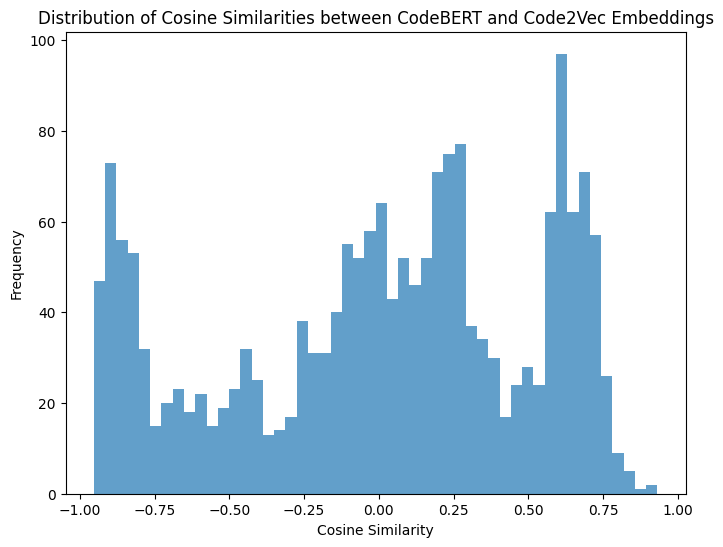

In [ ]:
import matplotlib.pyplot as plt

# Plot histogram of cosine similarities
plt.figure(figsize=(8, 6))
plt.hist(similarity_list, bins=50, alpha=0.7)
plt.title('Distribution of Cosine Similarities between CodeBERT and Code2Vec Embeddings')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()


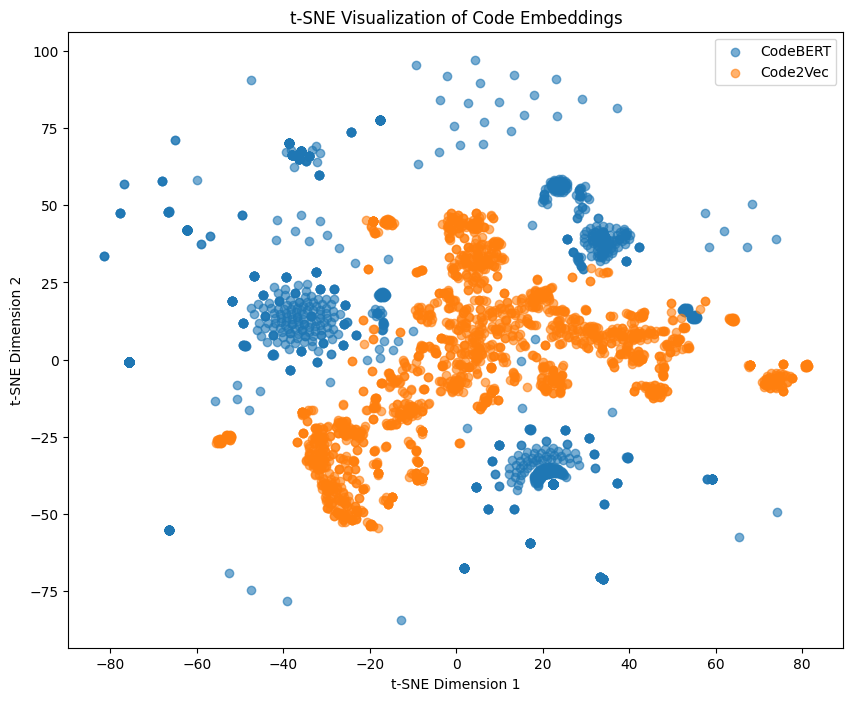

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Concatenate embeddings for t-SNE
combined_embeddings = np.concatenate((codebert_vectors_pca, code2vec_vectors_pca_sampled), axis=0)
labels = ['CodeBERT'] * codebert_vectors_pca.shape[0] + ['Code2Vec'] * code2vec_vectors_pca_sampled.shape[0]

# Reduce dimensions to 2D for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_tsne = tsne.fit_transform(combined_embeddings)

# Split the transformed embeddings back into CodeBERT and Code2Vec
codebert_tsne = embeddings_tsne[:codebert_vectors_pca.shape[0], :]
code2vec_tsne = embeddings_tsne[codebert_vectors_pca.shape[0]:, :]

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
plt.scatter(codebert_tsne[:, 0], codebert_tsne[:, 1], label="CodeBERT", alpha=0.6)
plt.scatter(code2vec_tsne[:, 0], code2vec_tsne[:, 1], label="Code2Vec", alpha=0.6)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Code Embeddings')
plt.legend()
plt.show()


In [ ]:
from sklearn.cluster import KMeans

# Define number of clusters (adjust as needed)
n_clusters = 10

# KMeans clustering on CodeBERT embeddings
kmeans_codebert = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_codebert_labels = kmeans_codebert.fit_predict(codebert_vectors_pca)

# KMeans clustering on Code2Vec embeddings
kmeans_code2vec = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_code2vec_labels = kmeans_code2vec.fit_predict(code2vec_vectors_pca_sampled)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


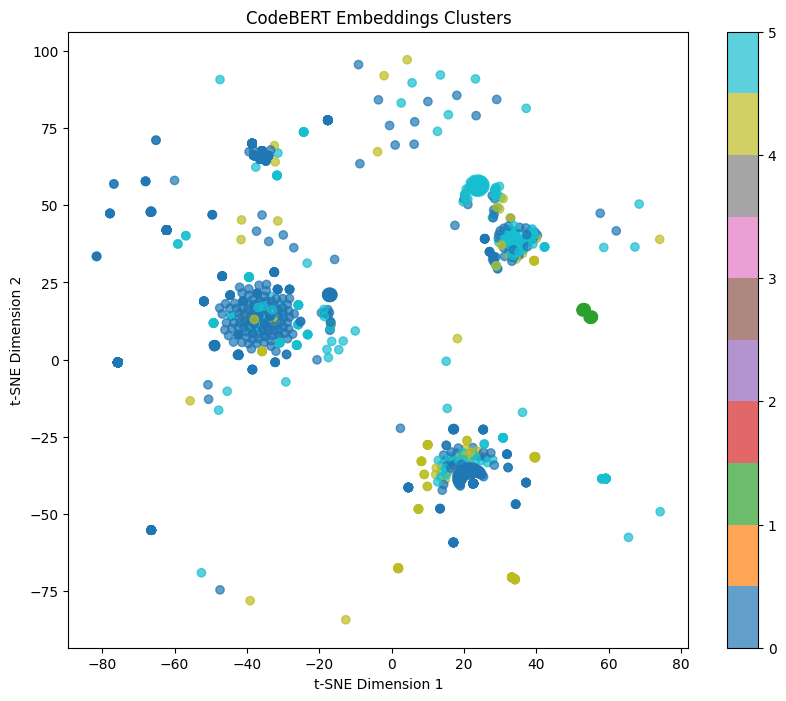

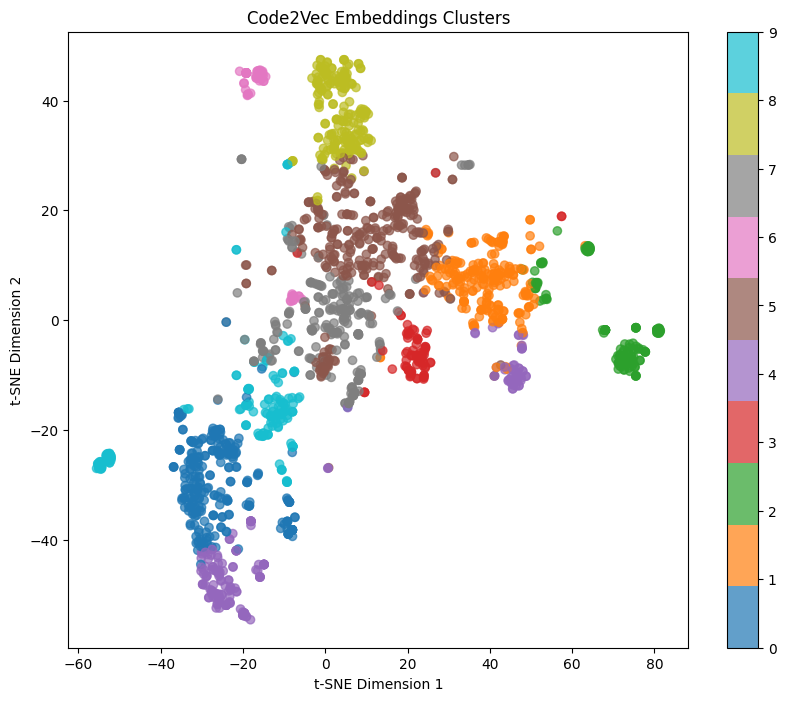

In [ ]:
# Plot CodeBERT Clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(codebert_tsne[:, 0], codebert_tsne[:, 1], c=kmeans_codebert_labels, cmap='tab10', alpha=0.7)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('CodeBERT Embeddings Clusters')
plt.colorbar(scatter, ticks=range(n_clusters))
plt.show()

# Plot Code2Vec Clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(code2vec_tsne[:, 0], code2vec_tsne[:, 1], c=kmeans_code2vec_labels, cmap='tab10', alpha=0.7)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Code2Vec Embeddings Clusters')
plt.colorbar(scatter, ticks=range(n_clusters))
plt.show()


### **Code Defect Prediction**

In [ ]:
!pip install scikit-learn


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from google.colab import files

# Upload the CSV files for ANT versions 1.5, 1.6, and 1.7
uploaded = files.upload()


Saving ant_1.7.csv to ant_1.7.csv
Saving ant-1.5.csv to ant-1.5 (1).csv
Saving ant-1.6-Unified.csv to ant-1.6-Unified.csv


In [ ]:
import pandas as pd

# Load the CSV files into DataFrames
ant_15_df = pd.read_csv('ant-1.5.csv')
ant_16_df = pd.read_csv('ant-1.6-Unified.csv')
ant_17_df = pd.read_csv('ant_1.7.csv')

# Display the first few rows to understand the structure
print("Ant 1.5 Data:")
print(ant_15_df.head())
print("\nAnt 1.6 Data:")
print(ant_16_df.head())
print("\nAnt 1.7 Data:")
print(ant_17_df.head())


Ant 1.5 Data:
     ID   Type     Name LongName Parent Component  \
0  L284  Class        A        A   L104      L103   
1  L301  Class        A        A   L104      L103   
2  L307  Class        A        A   L104      L103   
3  L315  Class        A        A   L104      L103   
4  L303  Class  A$Inner  A$Inner   L301      L103   

                                                Path  Line  Column  EndLine  \
0  src/etc/testcases/taskdefs/optional/depend/src...     1       1        3   
1  src/etc/testcases/taskdefs/optional/depend/src...     1       1        4   
2  src/etc/testcases/taskdefs/optional/depend/src...     1       1        6   
3  src/etc/testcases/taskdefs/optional/depend/src...     1       1        3   
4  src/etc/testcases/taskdefs/optional/depend/src...     2       5        3   

   ...  dam  moa  mfa  cam  ic  cbm  amc  max_cc  avg_cc  bug  
0  ...  NaN  NaN  NaN  NaN NaN  NaN  NaN     NaN     NaN  NaN  
1  ...  NaN  NaN  NaN  NaN NaN  NaN  NaN     NaN     NaN  NaN  


In [ ]:
# Display column names of each DataFrame
print("Ant 1.5 Columns:")
print(ant_15_df.columns.tolist())
print("\nAnt 1.6 Columns:")
print(ant_16_df.columns.tolist())
print("\nAnt 1.7 Columns:")
print(ant_17_df.columns.tolist())


Ant 1.5 Columns:
['ID', 'Type', 'Name', 'LongName', 'Parent', 'Component', 'Path', 'Line', 'Column', 'EndLine', 'EndColumn', 'CC', 'CCL', 'CCO', 'CI', 'CLC', 'CLLC', 'LDC', 'LLDC', 'LCOM5', 'NL', 'NLE', 'WMC', 'CBO', 'CBOI', 'NII', 'NOI', 'RFC', 'AD', 'CD', 'CLOC', 'DLOC', 'PDA', 'PUA', 'TCD', 'TCLOC', 'DIT', 'NOA', 'NOC', 'NOD', 'NOP', 'LLOC', 'LOC', 'NA', 'NG', 'NLA', 'NLG', 'NLM', 'NLPA', 'NLPM', 'NLS', 'NM', 'NOS', 'NPA', 'NPM', 'NS', 'TLLOC', 'TLOC', 'TNA', 'TNG', 'TNLA', 'TNLG', 'TNLM', 'TNLPA', 'TNLPM', 'TNLS', 'TNM', 'TNOS', 'TNPA', 'TNPM', 'TNS', 'name', 'version', 'name.1', 'wmc', 'dit', 'noc', 'cbo', 'rfc', 'lcom', 'ca', 'ce', 'npm', 'lcom3', 'loc', 'dam', 'moa', 'mfa', 'cam', 'ic', 'cbm', 'amc', 'max_cc', 'avg_cc', 'bug']

Ant 1.6 Columns:
['ID', 'Type', 'Name', 'LongName', 'Parent', 'Component', 'Path', 'Line', 'Column', 'EndLine', 'EndColumn', 'CC', 'CCL', 'CCO', 'CI', 'CLC', 'CLLC', 'LDC', 'LLDC', 'LCOM5', 'NL', 'NLE', 'WMC', 'CBO', 'CBOI', 'NII', 'NOI', 'RFC', 'AD', 'CD

In [ ]:
# For Ant 1.5 and Ant 1.6, columns are 'Name', 'Path', 'bug'
relevant_columns_ant15 = ['Name', 'Path', 'bug']
relevant_columns_ant16 = ['Name', 'Path', 'bug']

# For Ant 1.7, columns are 'name' (lowercase) and 'bug'
relevant_columns_ant17 = ['name', 'bug']

# Filter relevant columns for each DataFrame
ant_15_relevant = ant_15_df[relevant_columns_ant15]
ant_16_relevant = ant_16_df[relevant_columns_ant16]
ant_17_relevant = ant_17_df[relevant_columns_ant17]

# Display relevant data
print("Relevant Data for Ant 1.5:")
print(ant_15_relevant.head())
print("\nRelevant Data for Ant 1.7:")
print(ant_17_relevant.head())


Relevant Data for Ant 1.5:
      Name                                               Path  bug
0        A  src/etc/testcases/taskdefs/optional/depend/src...  NaN
1        A  src/etc/testcases/taskdefs/optional/depend/src...  NaN
2        A  src/etc/testcases/taskdefs/optional/depend/src...  NaN
3        A  src/etc/testcases/taskdefs/optional/depend/src...  NaN
4  A$Inner  src/etc/testcases/taskdefs/optional/depend/src...  NaN

Relevant Data for Ant 1.7:
                                                name  bug
0  org.apache.tools.ant.taskdefs.rmic.RmicAdapter...    0
1  org.apache.tools.ant.taskdefs.optional.perforc...    0
2  org.apache.tools.ant.taskdefs.optional.junit.O...    0
3  org.apache.tools.ant.taskdefs.optional.perforc...    0
4              org.apache.tools.ant.taskdefs.WaitFor    1


In [ ]:
import os

# Updated function to match file paths to defect labels
def get_defect_labels(file_paths, df, filename_column):
    labels = []
    for file_path in file_paths:
        # Extract the file name to match with the DataFrame's filename column
        file_name = os.path.basename(file_path)
        # Some filenames may have extensions; remove them if necessary
        file_name_no_ext = os.path.splitext(file_name)[0]
        # Attempt to match the file name
        label_row = df[df[filename_column].str.contains(file_name_no_ext, na=False)]
        if not label_row.empty:
            labels.append(label_row['bug'].values[0])
        else:
            labels.append(None)  # Handle unmatched cases
    return labels


### **CodeBERT**

In [ ]:
# Map labels to the Java files for ANT 1.7
test_files = [os.path.join(root, name)
              for root, dirs, files in os.walk(test_path)
              for name in files
              if name.endswith(".java")]

# Get labels for CodeBERT embeddings
codebert_labels = get_defect_labels(test_files, ant_17_relevant, 'name')

# Ensure that the labels are properly aligned
print(f"Total test files: {len(test_files)}")
print(f"Total labels retrieved: {len(codebert_labels)}")


Total test files: 1891
Total labels retrieved: 1891


In [ ]:
print(f"Number of test files: {len(test_files)}")
print(f"Number of labels: {len(codebert_labels)}")
print(f"Number of CodeBERT vectors: {codebert_vectors_pca.shape[0]}")


Number of test files: 1891
Number of labels: 1891
Number of CodeBERT vectors: 1888


In [ ]:
# Filter indices to be within bounds of `codebert_vectors_pca`
valid_indices = [i for i, label in enumerate(codebert_labels)
                 if pd.notna(label) and i < codebert_vectors_pca.shape[0]]

# Use the filtered indices for embeddings and labels
X_codebert = codebert_vectors_pca[valid_indices]
y_codebert = [codebert_labels[i] for i in valid_indices]

# Convert labels to integers if necessary
y_codebert = [int(label) for label in y_codebert]

print(f"Number of labeled samples: {len(y_codebert)}")


Number of labeled samples: 1503


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets (e.g., 80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_codebert, y_codebert, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Training set size: 1202
Test set size: 301


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize the classifier (you can also try other classifiers like XGBoost)
classifier = RandomForestClassifier(random_state=42)

# Train the classifier on the training data
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)


In [ ]:
# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")



Accuracy: 0.8206
Precision: 0.6734
Recall: 0.8206
F1-Score: 0.7397


### **Code2Vec**

In [ ]:
# Assuming the bug labels from ant-1.7.csv are to be used for Code2Vec as well
code2vec_labels = ant_17_df['bug']  # Ensure this is the correct column for defect labels
print(f"Number of Code2Vec labels: {len(code2vec_labels)}")


Number of Code2Vec labels: 745


In [ ]:
# Filter indices to ensure they are within bounds of `code2vec_vectors_pca`
valid_indices_code2vec = [i for i, label in enumerate(code2vec_labels)
                          if pd.notna(label) and i < code2vec_vectors_pca.shape[0]]

# Use the filtered indices for embeddings and labels
X_code2vec = code2vec_vectors_pca[valid_indices_code2vec]
y_code2vec = [code2vec_labels[i] for i in valid_indices_code2vec]

# Convert labels to integers if necessary
y_code2vec = [int(label) for label in y_code2vec]

print(f"Number of labeled samples for Code2Vec: {len(y_code2vec)}")


Number of labeled samples for Code2Vec: 745


In [ ]:
from sklearn.model_selection import train_test_split

# Split data for Code2Vec
X_train_code2vec, X_test_code2vec, y_train_code2vec, y_test_code2vec = train_test_split(
    X_code2vec, y_code2vec, test_size=0.3, random_state=42)

print(f"Code2Vec - Train size: {len(X_train_code2vec)}, Test size: {len(X_test_code2vec)}")


Code2Vec - Train size: 521, Test size: 224


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train classifier for Code2Vec
clf_code2vec = RandomForestClassifier(random_state=42)
clf_code2vec.fit(X_train_code2vec, y_train_code2vec)


RandomForestClassifier(random_state=42)

In [ ]:
# Make predictions for Code2Vec
y_pred_code2vec = clf_code2vec.predict(X_test_code2vec)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate performance for Code2Vec embeddings
accuracy_code2vec = accuracy_score(y_test_code2vec, y_pred_code2vec)
precision_code2vec = precision_score(y_test_code2vec, y_pred_code2vec, average='weighted', zero_division=0)
recall_code2vec = recall_score(y_test_code2vec, y_pred_code2vec, average='weighted', zero_division=0)
f1_code2vec = f1_score(y_test_code2vec, y_pred_code2vec, average='weighted', zero_division=0)

print(f"Code2Vec - Accuracy: {accuracy_code2vec:.4f}")
print(f"Code2Vec - Precision: {precision_code2vec:.4f}")
print(f"Code2Vec - Recall: {recall_code2vec:.4f}")
print(f"Code2Vec - F1-Score: {f1_code2vec:.4f}")


Code2Vec - Accuracy: 0.7679
Code2Vec - Precision: 0.6317
Code2Vec - Recall: 0.7679
Code2Vec - F1-Score: 0.6820
